# Typosquatted Domain Monitoring

Typosquatting is when a malicious actor purchases a domain that might be easily mistaken (either visually, or through a typo) for an existing domain tied to a reputable organisation. They can then use that domain for various purposes, including impersonating the website hosted at the impersonated domain to harvest credentials or mislead users, or to attack the organisation's reputation via vandalism.

Regarding domains that can look visually similar, there are plenty of characters that can be confused for one another, depending on the font used. Examples of sets of such characters are:
- The numeral one, a capital letter i, the lowercase letter L, and the pipe symbol: "1Il|" (`1Il|`)
- An uppercase letter o and the numeral zero: "O0" (`O0`)
- An uppercase letter s and the numeral 5: "S5" (`S5`)

And so on. These are commonly known about, and the choice of font in can help reduce the danger of mistaking one for the other. More dangerous, perhaps, are "homograph" attacks, where different Unicode codepoints have the same appearance, even under different points. This is to be expected given how languages with different scripts can still share the "same" letters - see the below Venn diagram of Greek, Latin and Cyrillic letters and which letters are common to others:
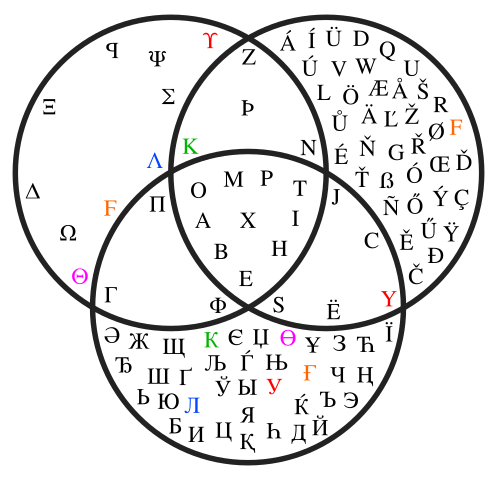

This has led to proof of concepts such as https://www.аррӏе.com/ (where [all the characters are actually in Cyrillic](https://unicode.scarfboy.com/?s=%D0%B0%D1%80%D1%80%D3%8F%D0%B5)). Unicode is aware of the problem, and have a utility to find "confusables" https://util.unicode.org/UnicodeJsps/confusables.jsp (along with the master data file that informs this tool, found here: https://www.unicode.org/Public/security/revision-03/confusablesSummary.txt).

Detecting these sorts of homograph attacks is unfortunately inconsistent, since different browsers behave differently upon being instructed to browse to a domain that can be confused for another one. It should be noted that domain names only ever in practice include ASCII characters; to support codepoints beyond that range, an encoding called [Punycode](https://en.wikipedia.org/wiki/Punycode) is used. Some browsers always display URLs as Punycode - some even go a step further, such as Microsoft Edge, and warn users that the domain is probably misleading:
<div>
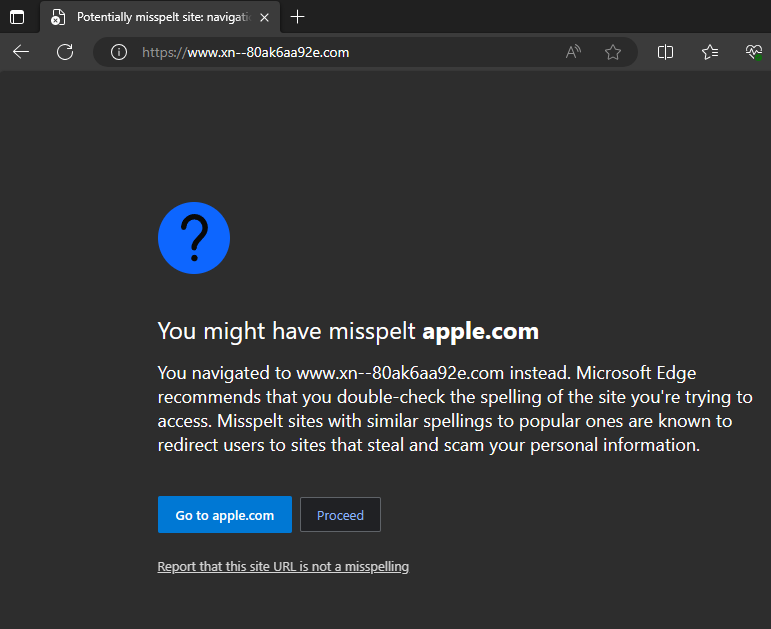
</div>

Firefox, on the other hand, renders the URL as-is and does not warn the user at all:

<div>
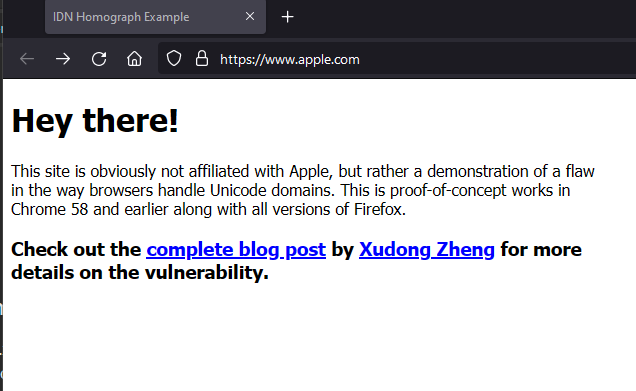
</div>

Because of this inconsistency, it's up to those that actually administer these domains to be proactive in reporting typosquatted domains, or even registering them pre-emptively. Once a typosquatted domain is found, it can be reported via sites such as those for [Google's Safe Browsing service](https://safebrowsing.google.com/safebrowsing/report_phish/) and [NCSC's own website](https://www.ncsc.gov.uk/section/about-this-website/report-scam-website).

# How to monitor for typosquatted domains
We want to have a program that takes a given domain name and then modify them with the following two slightly different transforms:
- Confusable characters
- Typoable characters (characters that don't look like each other but are close to each other on keyboards, e.g. j and k)